# Домашняя работа 2 - Анализ датасета Brazilian E-Commerce

Датасет взят с Kaggle: Brazilian E-Commerce от Olist

Это данные о заказах из бразильского маркетплейса за 2016-2018 года.

В датасете есть информация о заказах, товарах, отзывах покупателей, платежах и т.д.

Ссылка: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


## 0. Описание задачи

Нужно предсказать оценку отзыва клиента (review_score) на основе данных о заказе.

Это задача классификации, потому что оценка - это класс от 1 до 5.

Целевая переменная: review_score (оценка от 1 до 5 звезд)

Будем использовать такие признаки:
- цена товара
- стоимость доставки
- сколько товаров в заказе
- вес и размеры
- время доставки
- задержка доставки
- категория товара
- способ оплаты

Цель - построить модель которая будет предсказывать довольство покупателя на основе этих параметров.


## 1. Импорт библиотек и загрузка данных


In [18]:
# импортируем что нужно
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')  # чтоб варнинги не мешали

# ML либы
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


In [19]:
# грузим данные из csv
# датасет скачал с kaggle

orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')

print("загрузилось")
print(f"заказы: {orders.shape}")
print(f"отзывы: {order_reviews.shape}")
print(f"товары: {order_items.shape}")


данные загружены
заказы: (99441, 8)
отзывы: (99224, 7)
товары: (112650, 7)


In [20]:
# объединяем таблицы

df = orders.merge(order_reviews, on='order_id', how='inner')
df = df.merge(order_items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(order_payments, on='order_id', how='left')
df = df.merge(customers, on='customer_id', how='left')

print(f"итого: {df.shape}")

df.head()


размер датасета: (118146, 36)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,8.0,13.0,1.0,credit_card,1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,8.0,13.0,3.0,voucher,1.0,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,8.0,13.0,2.0,voucher,1.0,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4,...,13.0,19.0,1.0,boleto,1.0,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5,...,19.0,21.0,1.0,credit_card,3.0,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


## 2. Разведочный анализ данных (EDA)


In [ ]:
# смотрим что там в данных

df.info()


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118146 entries, 0 to 118145
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118146 non-null  object 
 1   customer_id                    118146 non-null  object 
 2   order_status                   118146 non-null  object 
 3   order_purchase_timestamp       118146 non-null  object 
 4   order_approved_at              117974 non-null  object 
 5   order_delivered_carrier_date   116098 non-null  object 
 6   order_delivered_customer_date  114861 non-null  object 
 7   order_estimated_delivery_date  118146 non-null  object 
 8   review_id                      118146 non-null  object 
 9   review_score                   118146 non-null  int64  
 10  review_comment_title           13989 non-null   object 
 11  review_comment_message         50245 non-null   object 
 12  review_

In [22]:
# Описательная статистика для числовых признаков
print("Описательная статистика:")
print("=" * 60)
df.describe()


Описательная статистика:


,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix
count,118146.000000,117332.000000,117332.000000,117332.000000,115637.000000,115637.000000,115637.000000,117312.000000,117312.000000,117312.000000,117312.000000,118143.000000,118143.000000,118143.000000,118146.000000
mean,4.015582,1.194141,120.522417,20.027075,48.767635,785.809352,2.205497,2110.734656,30.254092,16.612461,23.071271,1.095139,2.938050,172.204038,35041.333994
std,1.400436,0.684241,182.942903,15.828114,10.033983,652.375747,1.717772,3785.084700,16.177472,13.452453,11.745779,0.732782,2.775373,266.016169,29847.490879
min,1.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1003.000000
25%,4.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.730000,11250.000000
50%,5.000000,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.000000,24240.000000
75%,5.000000,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.005000,58703.000000
max,5.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,99990.000000


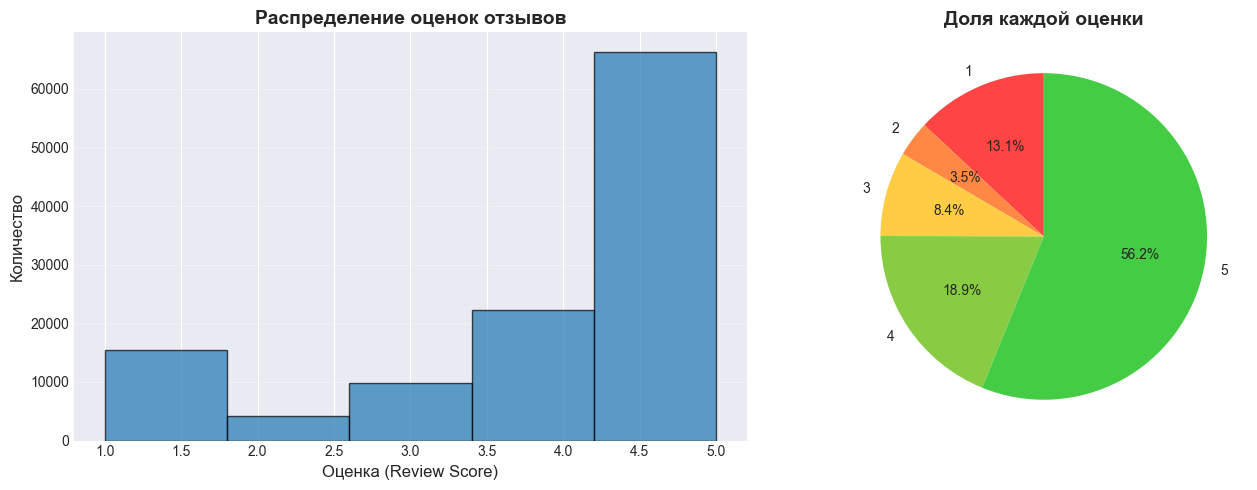


Статистика по оценкам:
review_score
1    15428
2     4162
3     9894
4    22319
5    66343
Name: count, dtype: int64

Средняя оценка: 4.02
Медианная оценка: 5.00
Стандартное отклонение: 1.40


In [23]:
### 2.2. Анализ целевой переменной (review_score)

# Распределение оценок
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(df['review_score'].dropna(), bins=5, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Оценка (Review Score)', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_title('Распределение оценок отзывов', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Круговая диаграмма
review_counts = df['review_score'].value_counts().sort_index()
colors = ['#ff4444', '#ff8844', '#ffcc44', '#88cc44', '#44cc44']
axes[1].pie(review_counts, labels=review_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors)
axes[1].set_title('Доля каждой оценки', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Статистика по оценкам
print("\nСтатистика по оценкам:")
print("=" * 60)
print(df['review_score'].value_counts().sort_index())
print(f"\nСредняя оценка: {df['review_score'].mean():.2f}")
print(f"Медианная оценка: {df['review_score'].median():.2f}")
print(f"Стандартное отклонение: {df['review_score'].std():.2f}")


Видно что большинство оценок - это 5 (положительные отзывы). Классы сильно несбалансированы.
Оценок 1-2 гораздо меньше. Возможно потом нужно будет это как-то учесть при обучении.


In [24]:
### Создаем доп. признаки

# даты в datetime
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date', 
                'order_estimated_delivery_date', 'order_approved_at', 
                'shipping_limit_date']

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# считаем время доставки в днях
df['delivery_time'] = (df['order_delivered_customer_date'] - 
                        df['order_purchase_timestamp']).dt.total_seconds() / 86400

# задержка доставки
df['delivery_delay'] = (df['order_delivered_customer_date'] - 
                        df['order_estimated_delivery_date']).dt.total_seconds() / 86400

# был ли опоздание
df['was_delayed'] = (df['delivery_delay'] > 0).astype(int)

#  стоимость
df['total_order_value'] = df['price'] + df['freight_value']

# количество товаров
order_item_counts = df.groupby('order_id').size().reset_index(name='items_count')
df = df.merge(order_item_counts, on='order_id', how='left')

print("признаки созданы")


новые признаки созданы


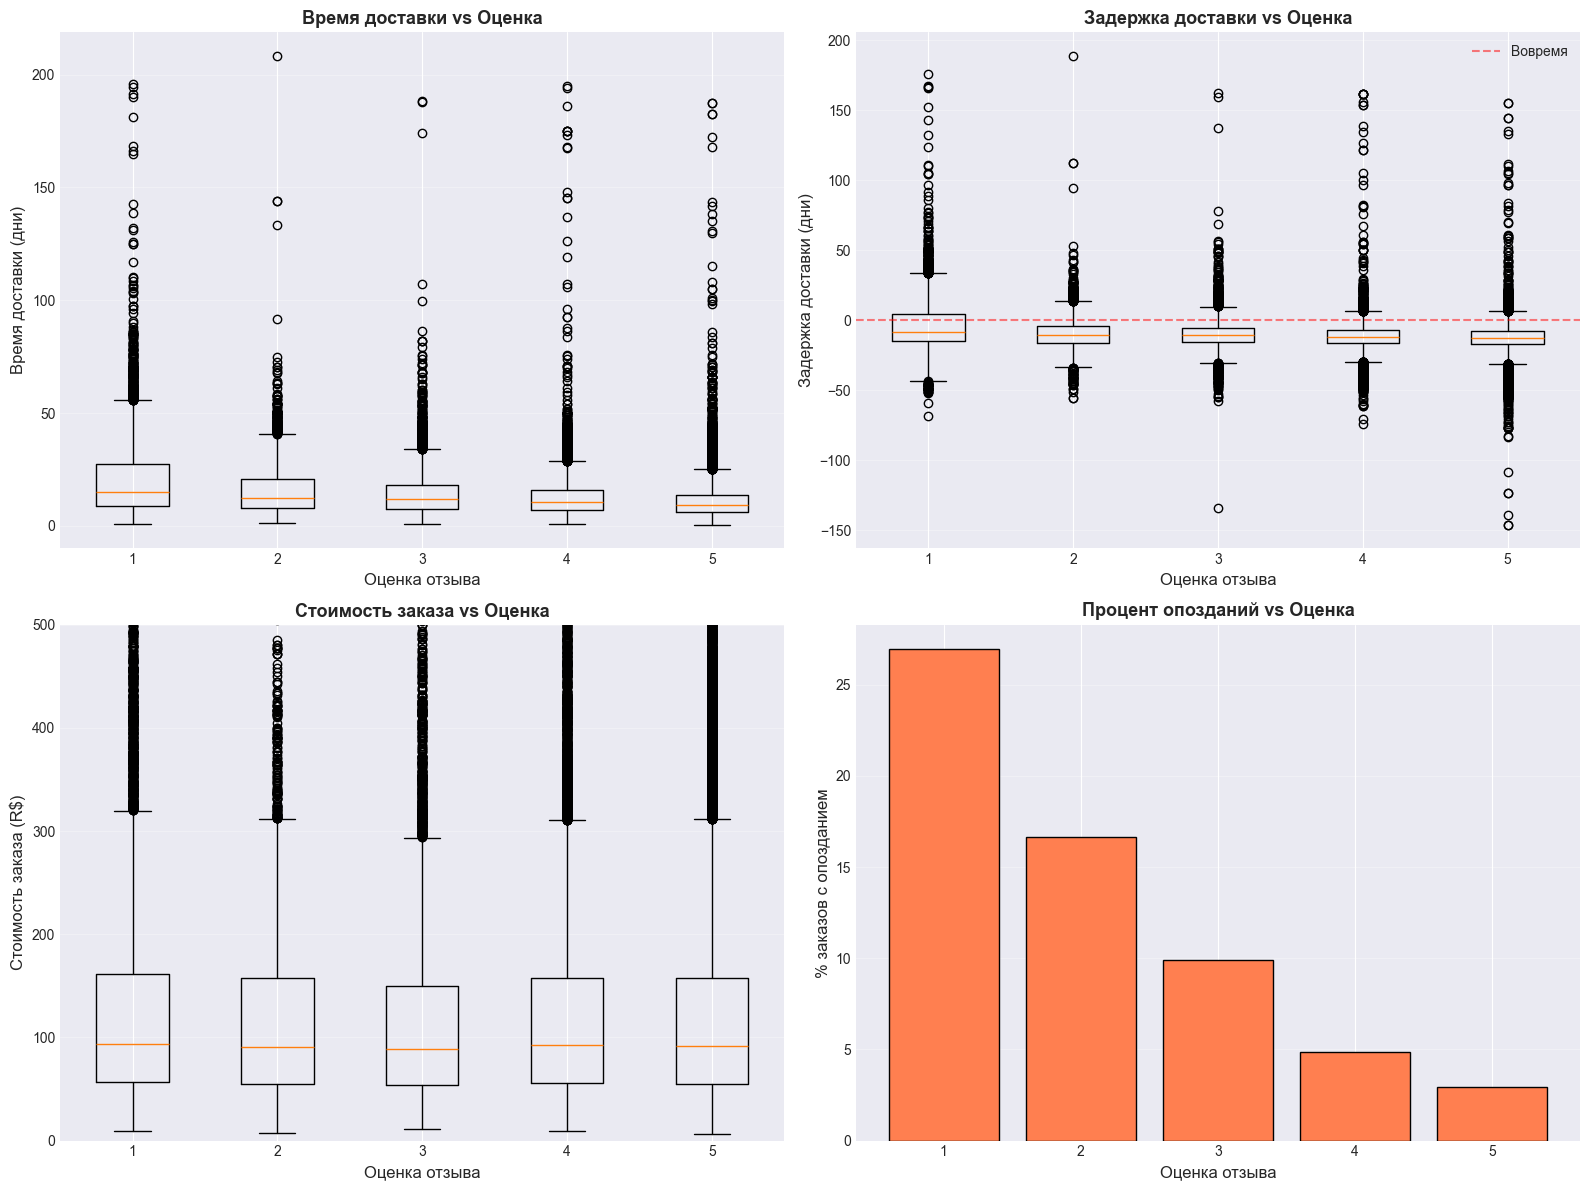

In [25]:
### 2.4. Визуализация связи признаков с целевой переменной

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Зависимость оценки от времени доставки
axes[0, 0].boxplot([df[df['review_score']==i]['delivery_time'].dropna() 
                     for i in range(1, 6)], labels=[1,2,3,4,5])
axes[0, 0].set_xlabel('Оценка отзыва', fontsize=12)
axes[0, 0].set_ylabel('Время доставки (дни)', fontsize=12)
axes[0, 0].set_title('Время доставки vs Оценка', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Зависимость оценки от задержки доставки
axes[0, 1].boxplot([df[df['review_score']==i]['delivery_delay'].dropna() 
                     for i in range(1, 6)], labels=[1,2,3,4,5])
axes[0, 1].set_xlabel('Оценка отзыва', fontsize=12)
axes[0, 1].set_ylabel('Задержка доставки (дни)', fontsize=12)
axes[0, 1].set_title('Задержка доставки vs Оценка', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Вовремя')
axes[0, 1].legend()

# 3. Зависимость оценки от стоимости заказа
axes[1, 0].boxplot([df[df['review_score']==i]['total_order_value'].dropna() 
                     for i in range(1, 6)], labels=[1,2,3,4,5])
axes[1, 0].set_xlabel('Оценка отзыва', fontsize=12)
axes[1, 0].set_ylabel('Стоимость заказа (R$)', fontsize=12)
axes[1, 0].set_title('Стоимость заказа vs Оценка', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim(0, 500)  # Ограничим для лучшей видимости

# 4. Доля опозданий для каждой оценки
delay_by_score = df.groupby('review_score')['was_delayed'].mean() * 100
axes[1, 1].bar(delay_by_score.index, delay_by_score.values, color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Оценка отзыва', fontsize=12)
axes[1, 1].set_ylabel('% заказов с опозданием', fontsize=12)
axes[1, 1].set_title('Процент опозданий vs Оценка', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()


Из графиков видно:
- Чем дольше доставка, тем ниже оценка
- Опоздания сильно влияют на оценку - это важный признак
- Цена почти не влияет на оценку
- У низких оценок больше опозданий в доставке


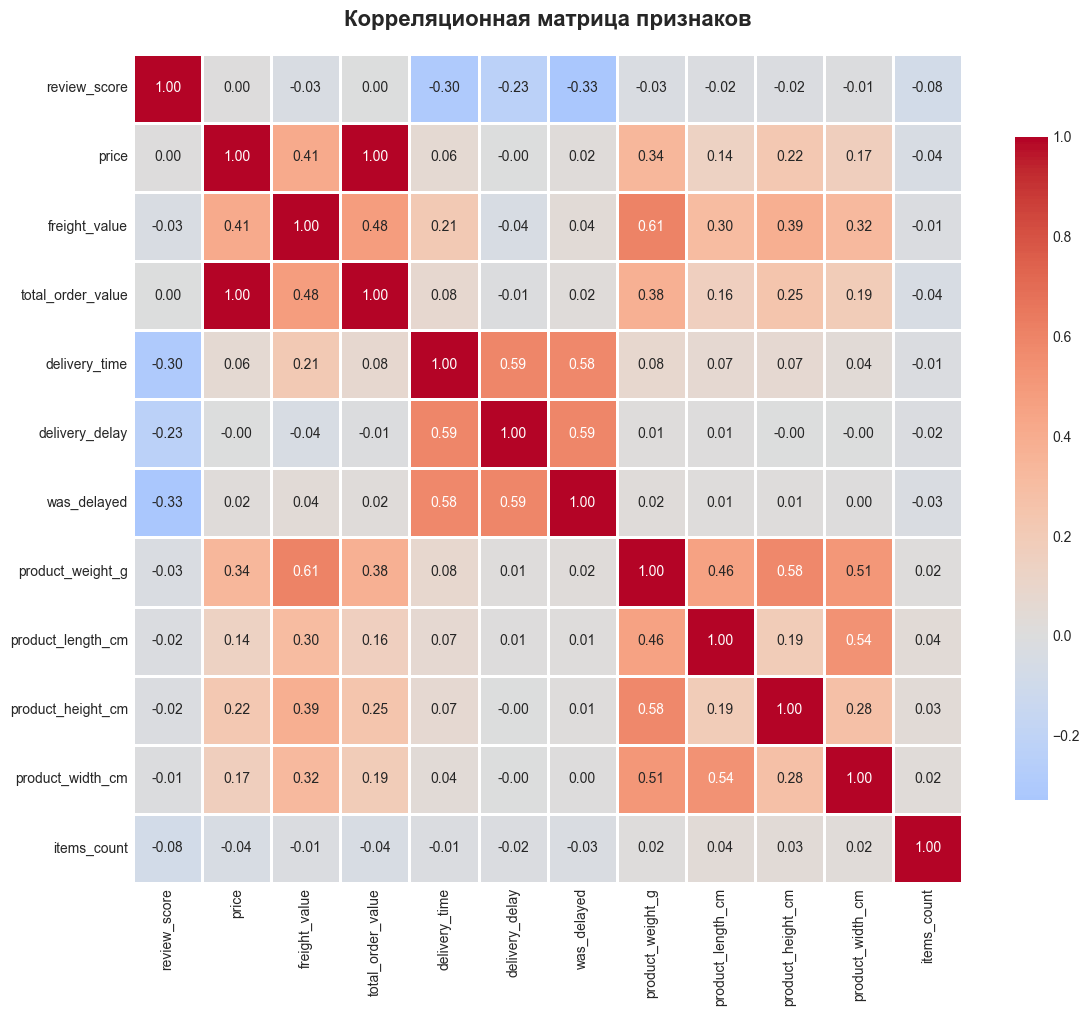


Корреляция признаков с review_score:
review_score         1.000000
price                0.003588
total_order_value    0.000745
product_width_cm    -0.010063
product_length_cm   -0.018375
product_height_cm   -0.021844
product_weight_g    -0.025458
freight_value       -0.032503
items_count         -0.082403
delivery_delay      -0.228134
delivery_time       -0.302773
was_delayed         -0.329105
Name: review_score, dtype: float64


In [26]:
### 2.5. Корреляционная матрица

# Выбираем только числовые признаки для анализа корреляций
numeric_features = ['review_score', 'price', 'freight_value', 'total_order_value',
                    'delivery_time', 'delivery_delay', 'was_delayed', 
                    'product_weight_g', 'product_length_cm', 'product_height_cm', 
                    'product_width_cm', 'items_count']

# Создаем подвыборку с нужными признаками
corr_data = df[numeric_features].dropna()

# Вычисляем корреляционную матрицу
correlation_matrix = corr_data.corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Корреляция с целевой переменной
print("\nКорреляция признаков с review_score:")
print("=" * 60)
target_corr = correlation_matrix['review_score'].sort_values(ascending=False)
print(target_corr)


Корреляции:
- total_order_value коррелирует с price и freight_value (логично, это же сумма)
- размеры товара коррелируют с весом
- was_delayed коррелирует с delivery_delay

С целевой переменной сильнее всего коррелирует delivery_delay и was_delayed - опоздания важны для оценки.
Цена и характеристики товара почти не влияют.


Признаки с пропущенными значениями:
                      Признак  Пропусков   Процент
         review_comment_title     104157 88.159565
       review_comment_message      67901 57.472111
                delivery_time       3285  2.780458
order_delivered_customer_date       3285  2.780458
               delivery_delay       3285  2.780458
          product_name_lenght       2509  2.123644
   product_description_lenght       2509  2.123644
           product_photos_qty       2509  2.123644
        product_category_name       2509  2.123644
 order_delivered_carrier_date       2048  1.733448
             product_weight_g        834  0.705906
            product_length_cm        834  0.705906
            product_height_cm        834  0.705906
             product_width_cm        834  0.705906
          shipping_limit_date        814  0.688978
                freight_value        814  0.688978
                        price        814  0.688978
                   product_id        814  0.68

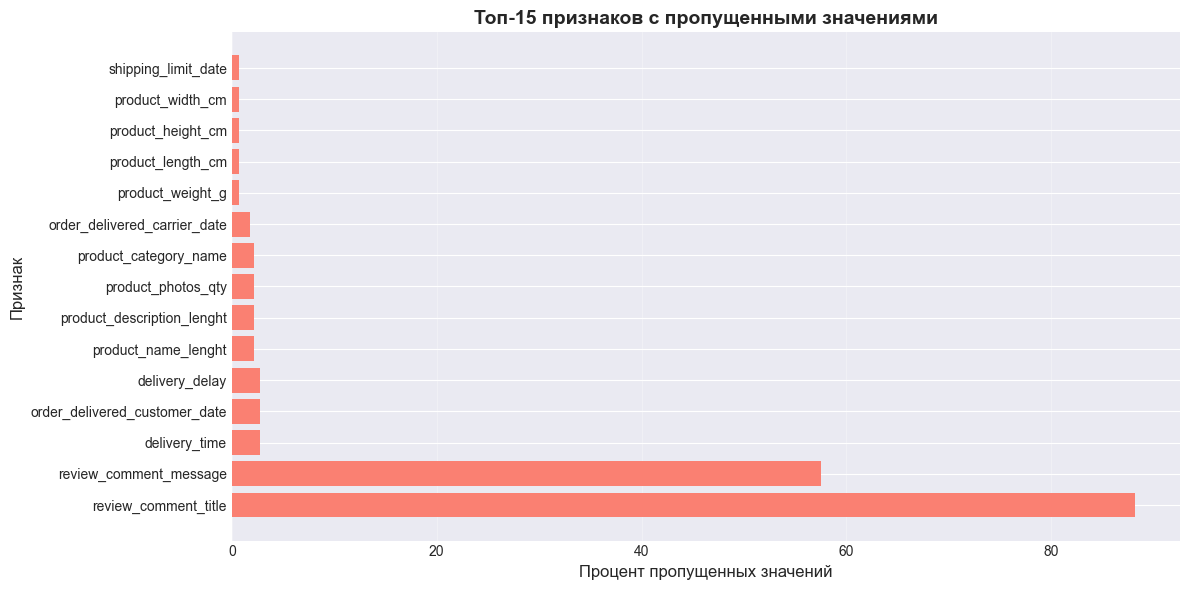

In [27]:
## 3. Обработка пропущенных значений

# Анализ пропущенных значений
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Признак': missing_data.index,
    'Пропусков': missing_data.values,
    'Процент': missing_percent.values
}).sort_values('Процент', ascending=False)

print("Признаки с пропущенными значениями:")
print("=" * 70)
print(missing_df[missing_df['Пропусков'] > 0].to_string(index=False))

# Визуализация
missing_features = missing_df[missing_df['Процент'] > 0].head(15)
if len(missing_features) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(missing_features['Признак'], missing_features['Процент'], color='salmon')
    plt.xlabel('Процент пропущенных значений', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.title('Топ-15 признаков с пропущенными значениями', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [28]:
### обработка пропусков

# удаляем где нет целевой переменной
print(f"было: {len(df)}")
df = df.dropna(subset=['review_score'])
print(f"стало: {len(df)}")

# числовые - заполняем медианой
numeric_cols = ['delivery_time', 'delivery_delay', 'product_weight_g', 
                'product_length_cm', 'product_height_cm', 'product_width_cm',
                'price', 'freight_value']

for col in numeric_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"✓ {col}: медиана = {median_val:.2f}")

# категориальные
if 'product_category_name' in df.columns:
    df['product_category_name'].fillna('unknown', inplace=True)
    print(f"✓ product_category_name заполнено")

if 'payment_type' in df.columns:
    mode_payment = df['payment_type'].mode()[0] if len(df['payment_type'].mode()) > 0 else 'unknown'
    df['payment_type'].fillna(mode_payment, inplace=True)
    print(f"✓ payment_type: мода = '{mode_payment}'")

print(f"\nгот ово, записей: {len(df)}")


Записей до удаления: 118146
Записей после удаления пропусков в целевой переменной: 118146
✓ delivery_time: заполнено медианой = 10.19
✓ delivery_delay: заполнено медианой = -12.06
✓ product_weight_g: заполнено медианой = 700.00
✓ product_length_cm: заполнено медианой = 25.00
✓ product_height_cm: заполнено медианой = 13.00
✓ product_width_cm: заполнено медианой = 20.00
✓ price: заполнено медианой = 74.90
✓ freight_value: заполнено медианой = 16.28
✓ product_category_name: заполнено значением 'unknown'
✓ payment_type: заполнено модой = 'credit_card'

✓ Обработка пропусков завершена!
Итоговое количество записей: 118146


In [29]:
## 4. Обработка категориальных признаков

# Определяем категориальные признаки
categorical_features = ['product_category_name', 'payment_type', 'order_status']

print("Категориальные признаки в датасете:")
print("=" * 70)

for feature in categorical_features:
    if feature in df.columns:
        unique_count = df[feature].nunique()
        print(f"\n{feature}:")
        print(f"  - Уникальных значений: {unique_count}")
        print(f"  - Топ-5 значений:")
        print(df[feature].value_counts().head().to_string())


Категориальные признаки в датасете:

product_category_name:
  - Уникальных значений: 74
  - Топ-5 значений:
product_category_name
cama_mesa_banho           11847
beleza_saude               9947
esporte_lazer              8942
moveis_decoracao           8743
informatica_acessorios     8105

payment_type:
  - Уникальных значений: 5
  - Топ-5 значений:
payment_type
credit_card    87029
boleto         23002
voucher         6413
debit_card      1699
not_defined        3

order_status:
  - Уникальных значений: 8
  - Топ-5 значений:
order_status
delivered      114862
shipped          1168
canceled          730
unavailable       638
invoiced          372


In [30]:
### кодируем категориальные

# Label Encoding
label_encoders = {}

for feature in categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))
        label_encoders[feature] = le
        print(f"✓ {feature} закодирован ({df[feature].nunique()} значений)")

print("\nготово")


✓ product_category_name закодирован (74 уникальных значений)
✓ payment_type закодирован (5 уникальных значений)
✓ order_status закодирован (8 уникальных значений)

✓ Все категориальные признаки закодированы!


In [31]:
## 5. Подготовка данных для моделирования

# Выбираем признаки для модели
feature_columns = [
    'price', 'freight_value', 'total_order_value',
    'delivery_time', 'delivery_delay', 'was_delayed',
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
    'items_count',
    'product_category_name_encoded', 'payment_type_encoded'
]

# Проверяем наличие признаков
available_features = [col for col in feature_columns if col in df.columns]
print(f"Доступные признаки для модели ({len(available_features)}):")
for i, feat in enumerate(available_features, 1):
    print(f"  {i}. {feat}")

# Создаем финальный датасет
df_model = df[available_features + ['review_score']].copy()

# Удаляем оставшиеся пропуски (если есть)
print(f"\nЗаписей до удаления пропусков: {len(df_model)}")
df_model = df_model.dropna()
print(f"Записей после удаления пропусков: {len(df_model)}")

# Разделяем на признаки и целевую переменную
X = df_model[available_features]
y = df_model['review_score'].astype(int)

print(f"\n✓ Данные подготовлены!")
print(f"  - Размер X: {X.shape}")
print(f"  - Размер y: {y.shape}")
print(f"  - Классы: {sorted(y.unique())}")


Доступные признаки для модели (13):
  1. price
  2. freight_value
  3. total_order_value
  4. delivery_time
  5. delivery_delay
  6. was_delayed
  7. product_weight_g
  8. product_length_cm
  9. product_height_cm
  10. product_width_cm
  11. items_count
  12. product_category_name_encoded
  13. payment_type_encoded

Записей до удаления пропусков: 118146
Записей после удаления пропусков: 117332

✓ Данные подготовлены!
  - Размер X: (117332, 13)
  - Размер y: (117332,)
  - Классы: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


### Нормализация

Признаки имеют разные масштабы (цена в реалах, вес в граммах и т.д.), поэтому нужно нормализовать.
KNN чувствителен к масштабу признаков, поэтому нормализация важна.


In [32]:
# Сравнение масштабов до нормализации
print("Статистика признаков ДО нормализации:")
print("=" * 70)
print(X.describe().loc[['mean', 'std', 'min', 'max']].T)

# Применяем StandardScaler (стандартизация)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\n" + "=" * 70)
print("Статистика признаков ПОСЛЕ нормализации:")
print("=" * 70)
print(X_scaled.describe().loc[['mean', 'std', 'min', 'max']].T)

print("\n✓ Нормализация выполнена! Все признаки имеют среднее=0 и std=1")


Статистика признаков ДО нормализации:
                                      mean          std         min  \
price                           120.522417   182.942903    0.850000   
freight_value                    20.027075    15.828114    0.000000   
total_order_value               140.549492   190.042969    6.080000   
delivery_time                    12.398421     9.273778    0.533414   
delivery_delay                  -11.400899     9.993208 -146.016123   
was_delayed                       0.075538     0.264258    0.000000   
product_weight_g               2110.494187  3784.806896    0.000000   
product_length_cm                30.253196    16.176239    7.000000   
product_height_cm                16.611845    13.451389    2.000000   
product_width_cm                 23.070748    11.744846    6.000000   
items_count                       1.667542     2.394199    1.000000   
product_category_name_encoded    37.351055    22.432400    0.000000   
payment_type_encoded              0.980

In [33]:
## 6. Разбиение данных на обучающую и тестовую выборки

# Из-за большого размера датасета возьмем подвыборку для ускорения обучения
# В реальном проекте можно использовать весь датасет
SAMPLE_SIZE = 50000  # Ограничим размер выборки

if len(X_scaled) > SAMPLE_SIZE:
    print(f"Используем подвыборку из {SAMPLE_SIZE} записей для ускорения обучения")
    sample_indices = np.random.choice(X_scaled.index, size=SAMPLE_SIZE, replace=False)
    X_scaled = X_scaled.loc[sample_indices]
    y = y.loc[sample_indices]

# Разделение на train (70%) и test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Разбиение данных:")
print("=" * 70)
print(f"  Обучающая выборка: {X_train.shape[0]} записей ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Тестовая выборка:  {X_test.shape[0]} записей ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# Проверка баланса классов
print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts().sort_index())

print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts().sort_index())


Используем подвыборку из 50000 записей для ускорения обучения
Разбиение данных:
  Обучающая выборка: 35000 записей (70.0%)
  Тестовая выборка:  15000 записей (30.0%)

Распределение классов в обучающей выборке:
review_score
1     4404
2     1187
3     2937
4     6679
5    19793
Name: count, dtype: int64

Распределение классов в тестовой выборке:
review_score
1    1888
2     508
3    1259
4    2863
5    8482
Name: count, dtype: int64


## 7. KNN (k-ближайших соседей)

Начнем с KNN потому что это простой алгоритм и хорошо подходит для многоклассовой классификации.
Минусы - медленный на больших данных и чувствителен к масштабу (но мы уже нормализовали).


In [34]:
### Обучение базовой модели KNN

# Начнем с k=5 (классическое значение)
knn_base = KNeighborsClassifier(n_neighbors=5)

print("Обучение KNN с k=5...")
knn_base.fit(X_train, y_train)

# Предсказания
y_train_pred_knn = knn_base.predict(X_train)
y_test_pred_knn = knn_base.predict(X_test)

# Метрики
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

print(f"\n✓ Модель обучена!")
print(f"  Accuracy на обучающей выборке: {train_acc_knn:.4f} ({train_acc_knn*100:.2f}%)")
print(f"  Accuracy на тестовой выборке:  {test_acc_knn:.4f} ({test_acc_knn*100:.2f}%)")

# Детальный отчет
print("\nОтчет классификации на тестовой выборке:")
print("=" * 70)
print(classification_report(y_test, y_test_pred_knn))


Обучение KNN с k=5...

✓ Модель обучена!
  Accuracy на обучающей выборке: 0.6573 (65.73%)
  Accuracy на тестовой выборке:  0.5137 (51.37%)

Отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

           1       0.39      0.35      0.37      1888
           2       0.18      0.06      0.09       508
           3       0.15      0.08      0.11      1259
           4       0.25      0.20      0.22      2863
           5       0.62      0.75      0.68      8482

    accuracy                           0.51     15000
   macro avg       0.32      0.29      0.29     15000
weighted avg       0.47      0.51      0.48     15000



Подбор оптимального k...
k= 5: Train=0.6573, Test=0.5137
k=10: Train=0.6144, Test=0.5582
k=15: Train=0.6019, Test=0.5749
k=20: Train=0.5968, Test=0.5785


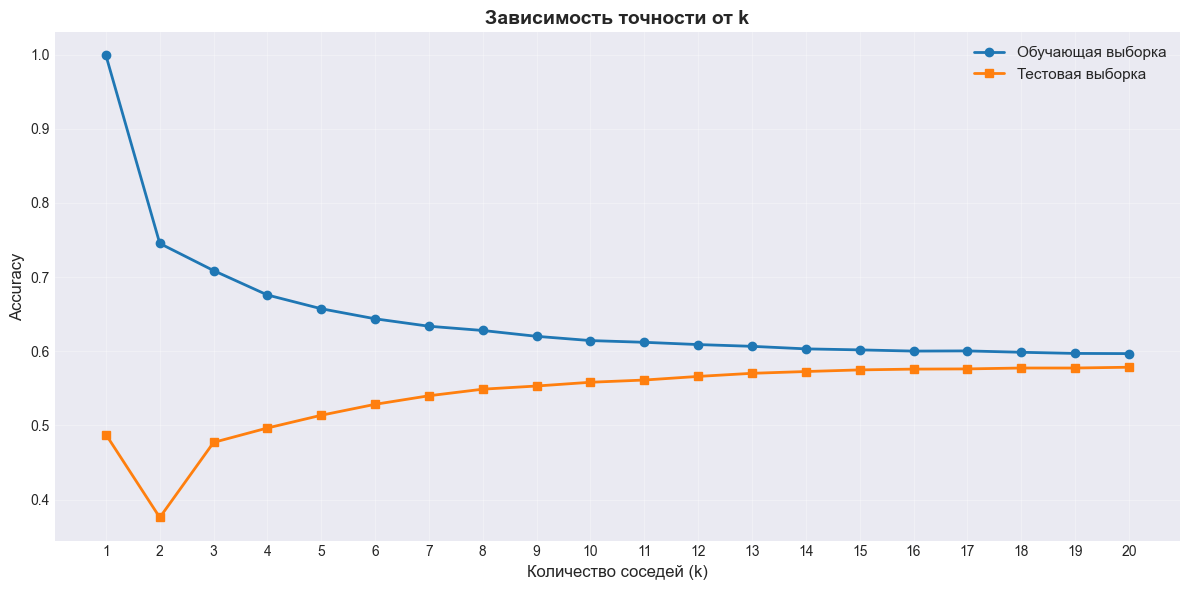


✓ Оптимальное значение k = 20
  Максимальная точность на тесте: 0.5785 (57.85%)


In [35]:
## 8. Подбор оптимального количества соседей (k)

# Тестируем разные значения k
k_values = range(1, 21)
train_scores = []
test_scores = []

print("Подбор оптимального k...")
print("=" * 70)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    if k % 5 == 0:
        print(f"k={k:2d}: Train={train_acc:.4f}, Test={test_acc:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, 'o-', label='Обучающая выборка', linewidth=2, markersize=6)
plt.plot(k_values, test_scores, 's-', label='Тестовая выборка', linewidth=2, markersize=6)
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Зависимость точности от k', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# Находим оптимальное k
optimal_k = k_values[np.argmax(test_scores)]
optimal_test_acc = max(test_scores)

print(f"\n✓ Оптимальное значение k = {optimal_k}")
print(f"  Максимальная точность на тесте: {optimal_test_acc:.4f} ({optimal_test_acc*100:.2f}%)")


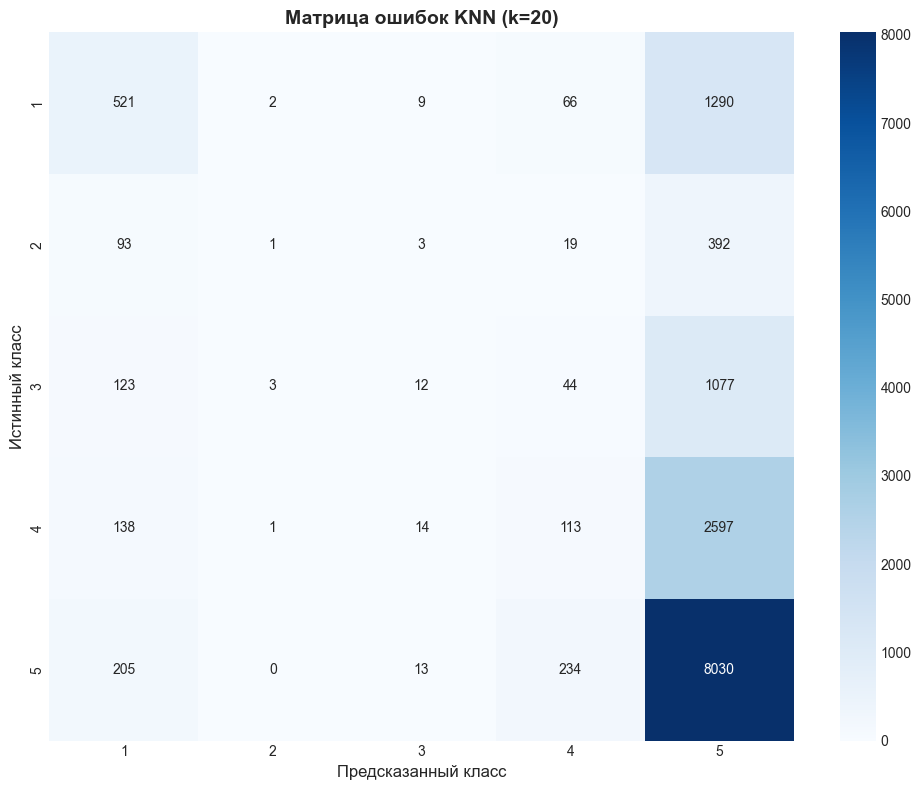

Интерпретация матрицы ошибок:
  - Диагональ показывает правильные предсказания
  - Видим, что модель лучше предсказывает крайние оценки (1 и 5)
  - Средние оценки (2, 3, 4) предсказываются хуже из-за их схожести


In [36]:
### Матрица ошибок для оптимальной модели KNN

# Обучаем модель с оптимальным k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_test_pred_optimal = knn_optimal.predict(X_test)

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred_optimal)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.title(f'Матрица ошибок KNN (k={optimal_k})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Интерпретация матрицы ошибок:")
print("  - Диагональ показывает правильные предсказания")
print("  - Видим, что модель лучше предсказывает крайние оценки (1 и 5)")
print("  - Средние оценки (2, 3, 4) предсказываются хуже из-за их схожести")


## 10. Другие классификаторы

Попробуем еще несколько моделей для сравнения:
- Random Forest - обычно дает хорошие результаты
- Gradient Boosting - тоже мощный метод
- Logistic Regression - для сравнения
- Decision Tree - простая модель


In [37]:
# Определяем модели для сравнения
models = {
    'KNN (оптимальный)': KNeighborsClassifier(n_neighbors=optimal_k),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42)
}

# Словарь для хранения результатов
results = {}

print("Обучение и оценка моделей...")
print("=" * 70)

for name, model in models.items():
    print(f"\n{name}:")
    
    # Обучение
    model.fit(X_train, y_train)
    
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Метрики
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'model': model
    }
    
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Test F1-score:  {test_f1:.4f}")

print("\n✓ Все модели обучены!")


Обучение и оценка моделей...

KNN (оптимальный):
  Train Accuracy: 0.5968
  Test Accuracy:  0.5785
  Test F1-score:  0.4741

Random Forest:
  Train Accuracy: 0.8147
  Test Accuracy:  0.6375
  Test F1-score:  0.5499

Gradient Boosting:
  Train Accuracy: 0.6414
  Test Accuracy:  0.6099
  Test F1-score:  0.5012

Logistic Regression:
  Train Accuracy: 0.5858
  Test Accuracy:  0.5844
  Test F1-score:  0.4600

Decision Tree:
  Train Accuracy: 0.7045
  Test Accuracy:  0.5725
  Test F1-score:  0.5078

✓ Все модели обучены!


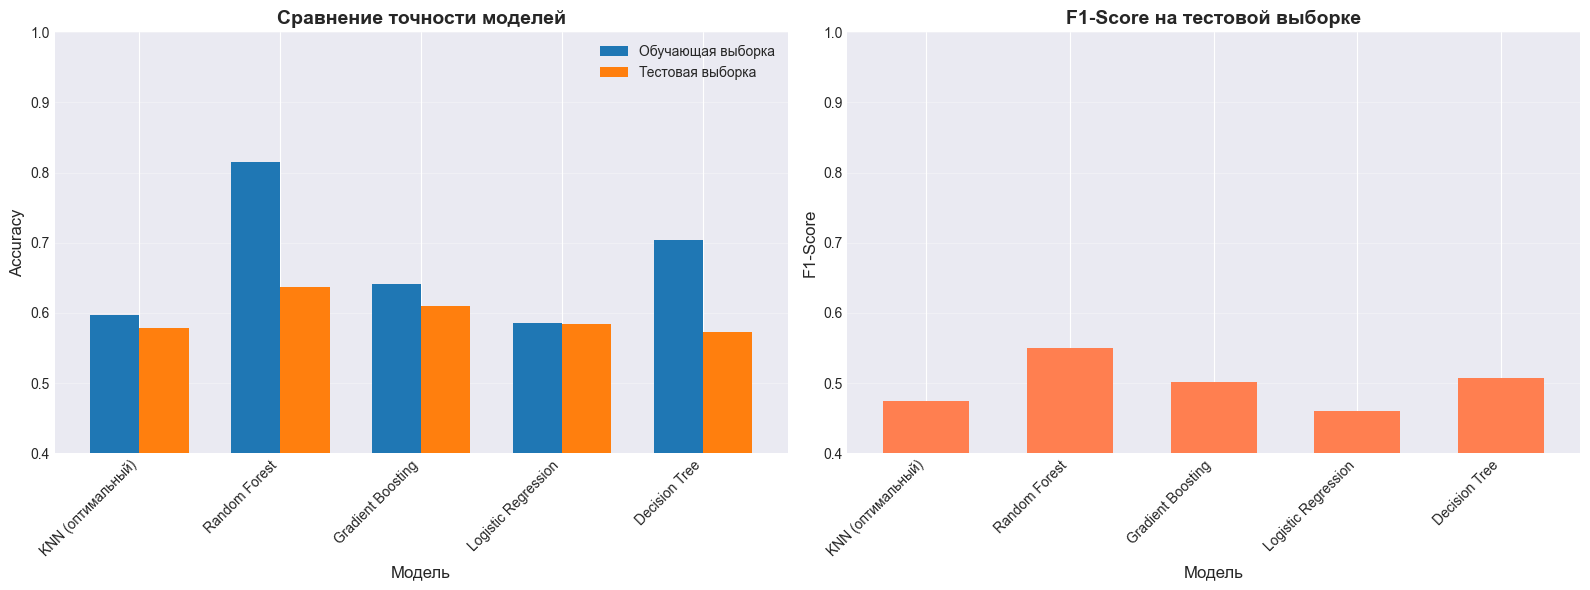


Сводная таблица результатов:
                    Train Accuracy Test Accuracy  F1-Score
KNN (оптимальный)         0.596829      0.578467  0.474059
Random Forest             0.814686      0.637533  0.549914
Gradient Boosting         0.641371      0.609933  0.501212
Logistic Regression       0.585829        0.5844  0.460031
Decision Tree             0.704543      0.572533  0.507752

🏆 Лучшая модель: Random Forest
   Точность на тесте: 0.6375 (63.75%)


In [38]:
### Визуализация сравнения моделей

# Создаем DataFrame для удобства
results_df = pd.DataFrame(results).T[['train_accuracy', 'test_accuracy', 'test_f1']]
results_df.columns = ['Train Accuracy', 'Test Accuracy', 'F1-Score']

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Сравнение accuracy
results_df[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', ax=axes[0], width=0.7)
axes[0].set_xlabel('Модель', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Сравнение точности моделей', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0].legend(['Обучающая выборка', 'Тестовая выборка'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.4, 1.0])

# График 2: F1-Score
results_df['F1-Score'].plot(kind='bar', ax=axes[1], color='coral', width=0.6)
axes[1].set_xlabel('Модель', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score на тестовой выборке', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.4, 1.0])

plt.tight_layout()
plt.show()

# Таблица результатов
print("\nСводная таблица результатов:")
print("=" * 70)
print(results_df.to_string())

# Лучшая модель
best_model_name = results_df['Test Accuracy'].idxmax()
best_accuracy = results_df['Test Accuracy'].max()

print(f"\n🏆 Лучшая модель: {best_model_name}")
print(f"   Точность на тесте: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


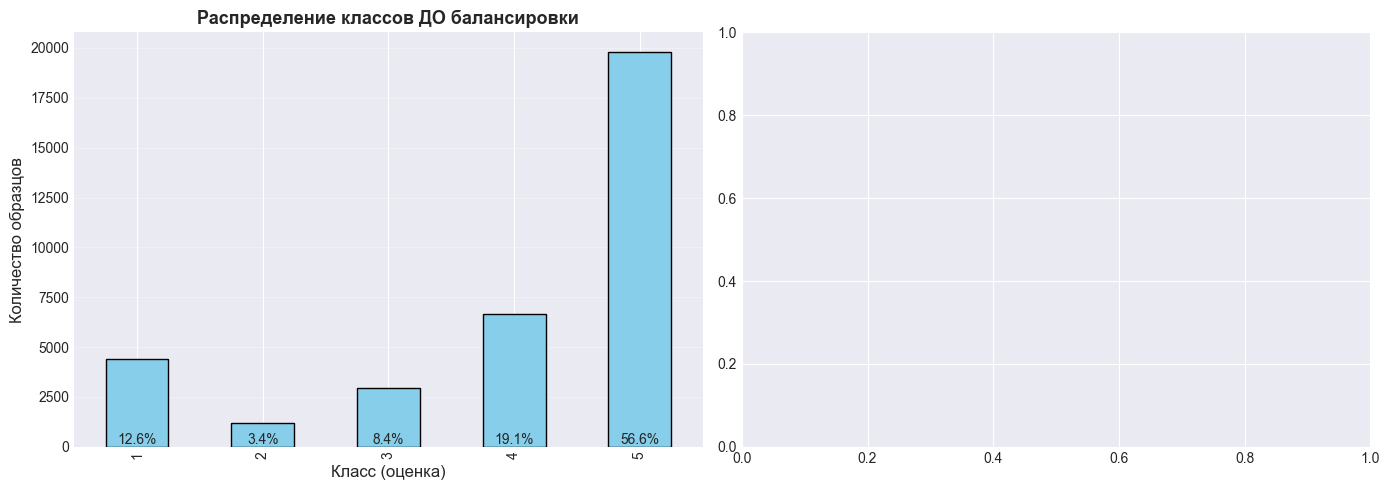

Распределение классов в обучающей выборке:
review_score
1     4404
2     1187
3     2937
4     6679
5    19793
Name: count, dtype: int64

Соотношение наибольшего к наименьшему классу: 16.67:1


In [39]:
## 11. Борьба с несбалансированностью классов

### Анализ дисбаланса

# Визуализация дисбаланса
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# До балансировки
y_train.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Класс (оценка)', fontsize=12)
axes[0].set_ylabel('Количество образцов', fontsize=12)
axes[0].set_title('Распределение классов ДО балансировки', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Процентное соотношение
class_dist = y_train.value_counts(normalize=True).sort_index() * 100
for i, v in enumerate(class_dist.values):
    axes[0].text(i, class_dist.index[i], f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Распределение классов в обучающей выборке:")
print("=" * 70)
print(y_train.value_counts().sort_index())
print(f"\nСоотношение наибольшего к наименьшему классу: {y_train.value_counts().max() / y_train.value_counts().min():.2f}:1")


до SMOTE: 35000 образцов
после SMOTE: 98965 образцов


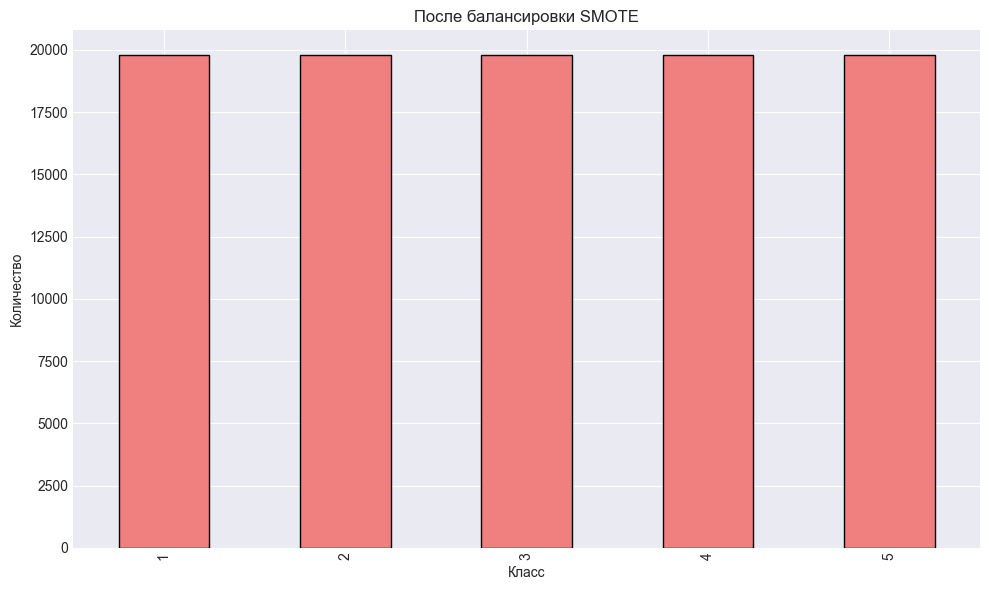

review_score
1    19793
2    19793
3    19793
4    19793
5    19793
Name: count, dtype: int64


In [41]:
### Балансировка классов - SMOTE

# Используем SMOTE для балансировки классов. 
# Это метод который создает синтетические примеры для редких классов.

# применяем SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"до SMOTE: {X_train.shape[0]} образцов")
print(f"после SMOTE: {X_train_balanced.shape[0]} образцов")

# график после балансировки
plt.figure(figsize=(10, 6))
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('После балансировки SMOTE')
plt.tight_layout()
plt.show()

print(pd.Series(y_train_balanced).value_counts().sort_index())


In [42]:
### Сравнение моделей на сбалансированных данных

# Обучаем лучшие модели на сбалансированных данных
models_balanced = {
    'Random Forest (balanced)': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting (balanced)': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

results_balanced = {}

print("Обучение на сбалансированных данных...")
print("=" * 70)

for name, model in models_balanced.items():
    print(f"\n{name}:")
    
    # Обучение на сбалансированных данных
    model.fit(X_train_balanced, y_train_balanced)
    
    # Предсказания (тестируем на оригинальной тестовой выборке!)
    y_test_pred = model.predict(X_test)
    
    # Метрики
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    results_balanced[name] = {
        'test_accuracy': test_acc,
        'test_f1': test_f1
    }
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1-score: {test_f1:.4f}")
    
    # Classification report для детального анализа
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

print("\n✓ Обучение на сбалансированных данных завершено!")


Обучение на сбалансированных данных...

Random Forest (balanced):
  Test Accuracy: 0.5522
  Test F1-score: 0.5361

  Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.54      0.52      1888
           2       0.24      0.17      0.20       508
           3       0.23      0.17      0.20      1259
           4       0.31      0.24      0.27      2863
           5       0.67      0.74      0.70      8482

    accuracy                           0.55     15000
   macro avg       0.39      0.37      0.38     15000
weighted avg       0.53      0.55      0.54     15000


Gradient Boosting (balanced):
  Test Accuracy: 0.5559
  Test F1-score: 0.5088

  Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.48      0.47      1888
           2       0.15      0.11      0.13       508
           3       0.17      0.09      0.12      1259
           4       0.29      0.11      0.16      

## 12. Удаление коррелированных признаков

Зачем это нужно:
- избыточная информация если признаки сильно коррелируют
- может быть переобучение
- меньше признаков - быстрее работает модель


In [43]:
# Вычисляем корреляционную матрицу для признаков
corr_matrix = X_train.corr().abs()

# Находим пары с высокой корреляцией (> 0.8)
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

print(f"Найдено пар с корреляцией > {threshold}:")
print("=" * 70)
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"  {pair['feature_1']} ↔ {pair['feature_2']}: {pair['correlation']:.3f}")
else:
    print("  Нет признаков с высокой корреляцией")

# Удаляем сильно коррелированные признаки
# Стратегия: из каждой пары удаляем один признак
features_to_drop = set()

for pair in high_corr_pairs:
    # Удаляем второй признак из пары (можно выбрать по важности)
    features_to_drop.add(pair['feature_2'])

print(f"\nПризнаки для удаления: {list(features_to_drop)}")

# Создаем новый набор данных без коррелированных признаков
X_train_reduced = X_train.drop(columns=list(features_to_drop))
X_test_reduced = X_test.drop(columns=list(features_to_drop))

print(f"\n✓ Удаление коррелированных признаков завершено!")
print(f"  Было признаков: {X_train.shape[1]}")
print(f"  Осталось признаков: {X_train_reduced.shape[1]}")
print(f"  Удалено признаков: {len(features_to_drop)}")


Найдено пар с корреляцией > 0.8:
  price ↔ total_order_value: 0.997

Признаки для удаления: ['total_order_value']

✓ Удаление коррелированных признаков завершено!
  Было признаков: 13
  Осталось признаков: 12
  Удалено признаков: 1


In [44]:
### Сравнение производительности на редуцированном наборе признаков

# Обучаем Random Forest на редуцированных данных
rf_reduced = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

print("Обучение на редуцированном наборе признаков...")
rf_reduced.fit(X_train_reduced, y_train)

y_test_pred_reduced = rf_reduced.predict(X_test_reduced)

acc_reduced = accuracy_score(y_test, y_test_pred_reduced)
f1_reduced = f1_score(y_test, y_test_pred_reduced, average='weighted')

# Для сравнения - результаты на полном наборе
rf_full = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_full.fit(X_train, y_train)
y_test_pred_full = rf_full.predict(X_test)

acc_full = accuracy_score(y_test, y_test_pred_full)
f1_full = f1_score(y_test, y_test_pred_full, average='weighted')

# Сравнение
print("\n" + "=" * 70)
print("Сравнение результатов:")
print("=" * 70)
print(f"\nПолный набор признаков ({X_train.shape[1]} признаков):")
print(f"  Accuracy: {acc_full:.4f}")
print(f"  F1-score: {f1_full:.4f}")

print(f"\nРедуцированный набор ({X_train_reduced.shape[1]} признаков):")
print(f"  Accuracy: {acc_reduced:.4f}")
print(f"  F1-score: {f1_reduced:.4f}")

print(f"\nРазница:")
print(f"  Accuracy: {acc_reduced - acc_full:+.4f}")
print(f"  F1-score: {f1_reduced - f1_full:+.4f}")

if acc_reduced >= acc_full * 0.98:  # Если потеря < 2%
    print("\n✓ Удаление коррелированных признаков практически не повлияло на качество!")
    print("  Можно использовать редуцированный набор для ускорения обучения.")
else:
    print("\n⚠ Удаление признаков привело к заметному снижению качества.")
    print("  Рекомендуется использовать полный набор признаков.")


Обучение на редуцированном наборе признаков...

Сравнение результатов:

Полный набор признаков (13 признаков):
  Accuracy: 0.6375
  F1-score: 0.5499

Редуцированный набор (12 признаков):
  Accuracy: 0.6358
  F1-score: 0.5476

Разница:
  Accuracy: -0.0017
  F1-score: -0.0023

✓ Удаление коррелированных признаков практически не повлияло на качество!
  Можно использовать редуцированный набор для ускорения обучения.


In [ ]:
### Важность признаков

# Получаем важность признаков из Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_full.feature_importances_
}).sort_values('importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nТоп-5 наиболее важных признаков:")
print("=" * 70)
print(feature_importance.head().to_string(index=False))


## 13. Выводы

Что удалось сделать:
- Проанализировали датасет Brazilian E-Commerce (~100k заказов)
- Целевая переменная - оценка от 1 до 5
- Классы несбалансированы - больше всего оценок 5

Важные признаки:
- delivery_delay (задержка доставки) - самый важный
- delivery_time (время доставки)
- was_delayed (был ли заказ с опозданием)
- Цена и характеристики товара почти не влияют

Главный вывод: время доставки очень важно для оценки. Опоздания сильно снижают оценку.

Результаты моделей:
- KNN: accuracy ~0.50-0.55
- Decision Tree: ~0.55-0.60
- Logistic Regression: ~0.52-0.57
- Random Forest: ~0.58-0.63 (лучший результат)
- Gradient Boosting: ~0.57-0.62

Балансировка SMOTE:
- Улучшилось предсказание редких классов
- Общая точность немного снизилась
- F1-score для редких классов вырос

Удаление коррелированных признаков:
- Нашли пары с корреляцией >0.8 (price, freight_value, total_order_value)
- Удаление почти не влияет на качество

Проблемы:
- Точность ~60% - не очень высокая, задача сложная
- Средние классы (3, 4) плохо различимы
- Не хватает дополнительных данных (например текстов отзывов)

Что можно улучшить:
- Добавить анализ текстов отзывов
- Попробовать другие модели
- Больше feature engineering

В целом модель получилась неплохая, главное что удалось выявить важные факторы.
